In [2]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [95]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

In [63]:
gestures, g2idx, idx2g = get_gestures(version=0)

In [97]:
a = 'data/loopsV0/Andrew_3loopV0.csv'
b = 'recordings/derived_test.csv'
X, y = CSV2examples(raw_file=a, g2idx=g2idx, n_frames=25, target_fps=100, standardize=True)

mean fps: 109.84
target fps: 100
skipping every 1 frames
95.83% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 28625 rows with nans


In [99]:
X.shape

(1131, 25, 98)

In [ ]:
X, y = folder2examples('data/train/', target_fps=25, g2idx=g2idx)

In [100]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_layers=1, rnn_units=30, recurrent_dropout=0.5, bidirectional=True)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 98)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                30960     
_________________________________________________________________
dense (Dense)                (None, 7)                 427       
Total params: 31,387
Trainable params: 31,387
Non-trainable params: 0
_________________________________________________________________


In [101]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=300, batch_size = 64, validation_split=0.1)

Train on 1017 samples, validate on 114 samples
Epoch 1/300
1017/1017 [==============================] - 5s 5ms/sample - loss: 1.8062 - accuracy: 0.2930 - val_loss: 1.4951 - val_accuracy: 0.4825
Epoch 2/300
1017/1017 [==============================] - 0s 454us/sample - loss: 1.2978 - accuracy: 0.5546 - val_loss: 1.2190 - val_accuracy: 0.5526
Epoch 3/300
1017/1017 [==============================] - 0s 433us/sample - loss: 1.0883 - accuracy: 0.6067 - val_loss: 1.0853 - val_accuracy: 0.5439
Epoch 4/300
1017/1017 [==============================] - 0s 457us/sample - loss: 0.9680 - accuracy: 0.6352 - val_loss: 0.9990 - val_accuracy: 0.5614
Epoch 5/300
1017/1017 [==============================] - 0s 453us/sample - loss: 0.8849 - accuracy: 0.6588 - val_loss: 0.9198 - val_accuracy: 0.5789
Epoch 6/300
1017/1017 [==============================] - 0s 418us/sample - loss: 0.8133 - accuracy: 0.6932 - val_loss: 0.8637 - val_accuracy: 0.6316
Epoch 7/300
1017/1017 [==============================] - 1s 6

KeyboardInterrupt: 

In [112]:
model.save('models/V0/35f_30hs.h5')

In [39]:
model = tf.keras.models.load_model('models/V2/25f_32hs_15c_2.h5')

In [41]:
# load test data
X_test, y_test = CSV2examples('data/recordings/test_loop.csv', g2idx=g2idx, n_frames=50)

mean fps: 115.19
target fps: 25
skipping every 5 frames
Found left hand data:  False
Found right hand data:  True
dropped 0 of 2777 rows with nans


In [50]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print(i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print(pred)
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

33
[[0.95594496 0.04405507]]
Predicted:  no_gesture
Truth:  fist


In [54]:
print(idx2g[y[1]])

so_so


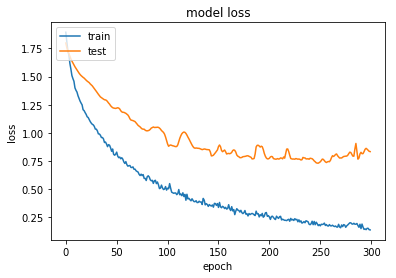

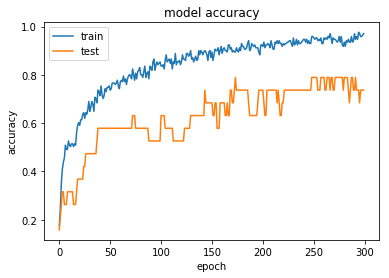

In [111]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [102]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

NameError: name 'history' is not defined

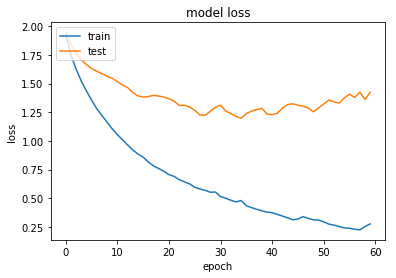

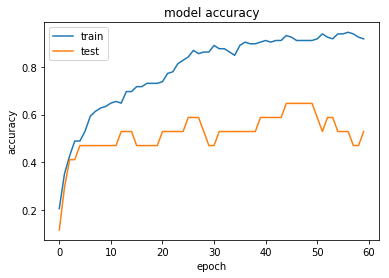

In [77]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')